# Temporal, 1-dimensional convolutions

As always:

In [4]:
# !pip install import-ipynb
!pip install torchtext==0.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 2.7 MB/s eta 0:00:00


In [5]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd gdrive/MyDrive/my_ml_2023/session-9

In [6]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torchtext
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import random

# import import_ipynb
import utils

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

# to get reproducible results:
torch.manual_seed(1234)
np.random.seed(1234)

Below, we'll work with `tensorflow_datasets`. For this, we need to install an additional dependency, `pydub`:

In [7]:
!pip install pydub

We can now import `tensorflow_datasets` -- check out the available datasets by uncommenting the second line.

In [8]:
import tensorflow_datasets as tfds
# tfds.list_builders()

We can now load the audio signals for each utterance, and the associated class labels. We load the single (?) split that seems to be available:

In [9]:
audio, digits = tfds.as_numpy(tfds.load(
    'spoken_digit', split='train',
    batch_size=-1, as_supervised=True,
))

print(type(audio), audio.shape)
print(type(digits), digits.shape)
digits[:10]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2500 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/spoken_digit/incomplete.X8P2G6_1.0.9/spoken_digit-train.tfrecord*...:   0%…

Dataset spoken_digit downloaded and prepared to /root/tensorflow_datasets/spoken_digit/1.0.9. Subsequent calls will reuse this data.
<class 'numpy.ndarray'> (2500, 18262)
<class 'numpy.ndarray'> (2500,)


array([2, 1, 9, 9, 7, 5, 3, 6, 1, 8])

Have a close look at the shape information: we have 2500 instances in total, for which the class labels (0-9) are given as flat vectors. The number of timesteps in each utterance is 18262, which means that we'll have to work with pretty lengthy vectors.

Let us plot the waveform of a single instance:

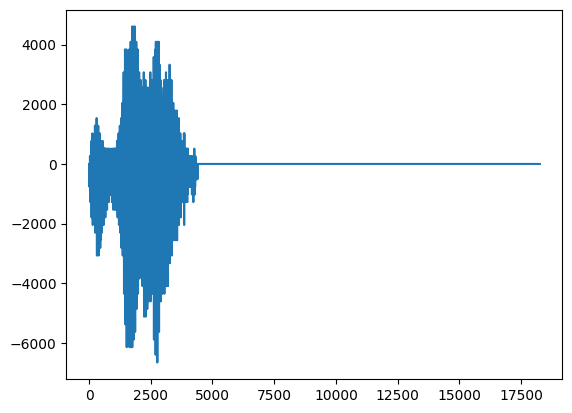

In [10]:
plt.plot(audio[1000]);

As you can see, the wave activity is concentrated to the left. We can zoom in on the relevant part to have a closer look at the structure of the wave. Here are the first 5000 timesteps:

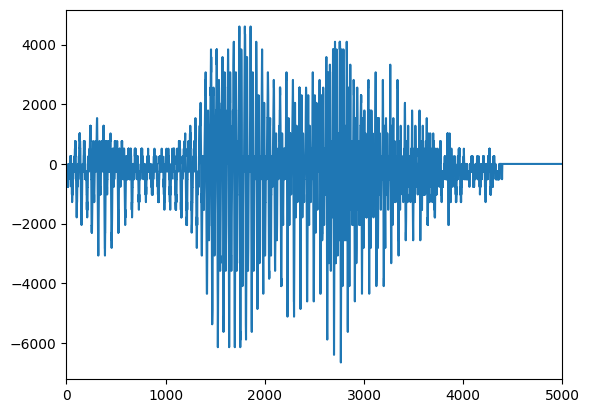

In [11]:
plt.plot(audio[1000])
plt.xlim([0, 5000]);

Or an even more finegrained view:

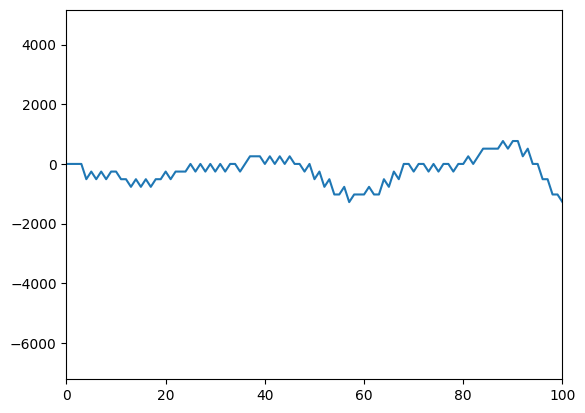

In [12]:
plt.plot(audio[1000])
plt.xlim([0, 100]);

The signal is amazingly detailed. Let us plot, for example, a couple of zeros (utterances that should have two discernable syllables).

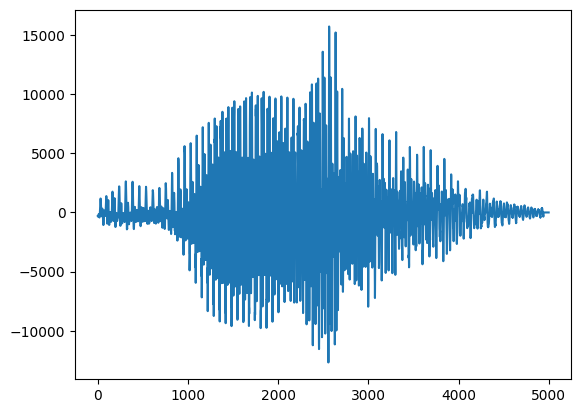

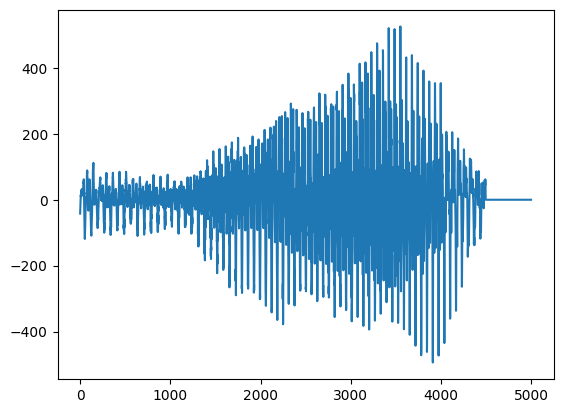

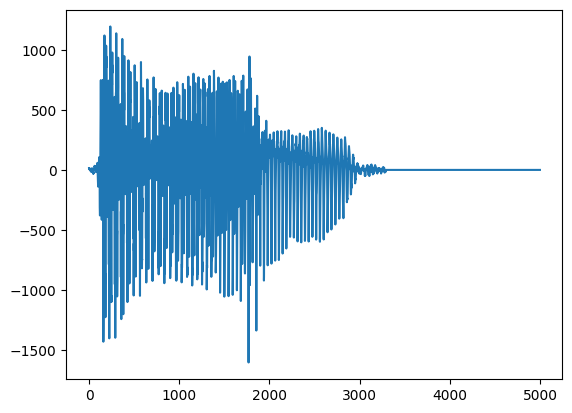

In [13]:
for zero in np.random.choice(np.where(digits == 0)[0].squeeze(), 3):
  plt.figure()
  plt.plot(audio[zero, :5000])

The syllables are somewhat hard to detect, but there seem to be two nuclei in the signal. That becomes clearer if we add a couple of (monosyllabic) "threes":

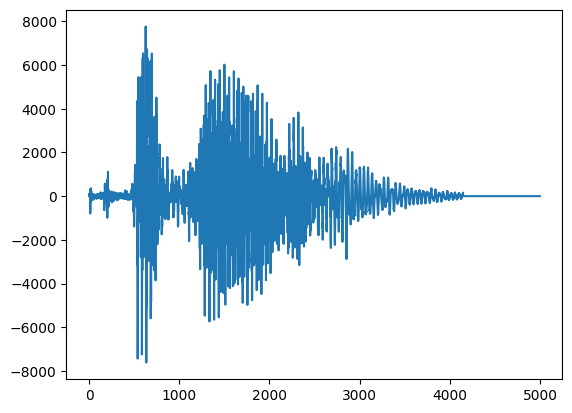

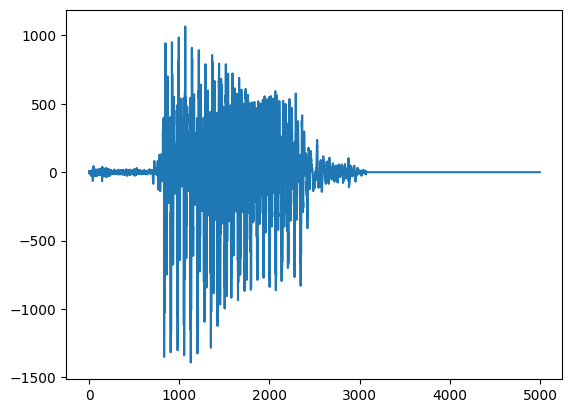

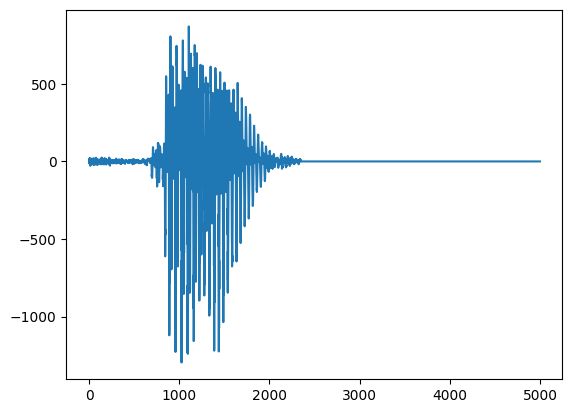

In [14]:
for three in np.random.choice(np.where(digits == 3)[0].squeeze(), 3):
  plt.figure()
  plt.plot(audio[three, :5000])

The examples above teach us that most digits are pronounced within the first 5000 timesteps in the signal (the rest of the signal are zeros). To decrease the length of this vector, we'll truncate it to the first 5,000 timesteps, using plain numpy indexing:

In [15]:
audio = audio[:, :5000]
print(audio.shape)

(2500, 5000)


Let's split our data:

In [16]:
from sklearn.model_selection import train_test_split

train_data, dev_test_data, train_labels, dev_test_labels = train_test_split(audio, digits, test_size=0.2,
                                                    random_state=1234, stratify=digits)

dev_data, test_data, dev_labels, test_labels = train_test_split(dev_test_data, dev_test_labels, test_size=0.5,
                                                    random_state=1234, stratify=dev_test_labels)


In [17]:
train_data.shape, train_labels.shape,  dev_labels.shape, dev_data.shape, test_data.shape, test_labels.shape

((2000, 5000), (2000,), (250,), (250, 5000), (250, 5000), (250,))

As usual:

In [18]:
def np2iter(x, y, shuffle=True):

  y = torch.tensor(y, dtype=torch.long)
  x = torch.tensor(x, dtype=torch.float)

  ds = torch.utils.data.TensorDataset(x, y)
  return torch.utils.data.DataLoader(ds, batch_size=64, shuffle=shuffle)

train_iter = np2iter(train_data, train_labels, shuffle=True)
dev_iter =  np2iter(dev_data, dev_labels, shuffle=False)
test_iter =  np2iter(test_data, test_labels, shuffle=False)

We are now ready to define the actual model. Pay attention to the incoming shapes:

In [19]:
class SimpleModel(nn.Module):
  def __init__(self):
    super(SimpleModel, self).__init__()
    self.cnn =  nn.Sequential(nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3),
                              nn.ReLU(),
                              nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3),
                              nn.ReLU(),
                              nn.MaxPool1d(8, 8),

                              nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3),
                              nn.ReLU(),
                              nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3),
                              nn.ReLU(),
                              nn.MaxPool1d(8, 8))


    self.linear =  nn.Sequential(nn.Linear(9856, 128),
                                nn.Linear(128, 10))


  def forward(self, x):
    x = torch.unsqueeze(x, 1)
    x = self.cnn(x)
    x = torch.flatten(x, start_dim=1, end_dim=- 1)
    x = self.linear(x)
    return x


In [20]:
def val_acc(y_pred, y_test):
  y_pred = np.argmax(y_pred, axis=1)
  return accuracy_score(y_pred=y_pred, y_true=y_test)

This is a very shallow network in the world of convolutional networks: we only have two "blocks". Here, we always have two `Conv1d` layers, which we feed through a `MaxPool1d` that from two consecutive convolution "pyramids" will select the single pyramid that had the highest activation.

The parameters of the Conv1D block require a bit more explanation: the first layer (`nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3)`) has 16 filters that each will be sled across the entire input vector. Their **receptive field** is three, meaning that the patterns which it will detect will cover three time steps. As we keep on stacking convolutions, you will often see that the number of filters goes up: that is deliberate and based on the assumption that higher layers in the network have to detect increasingly complex patterns.

In [34]:
simple_model = SimpleModel()
simple_model = simple_model.cuda()

history = utils.train(model=simple_model,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
              optimizer=torch.optim.Adam(simple_model.parameters(), lr=0.0001),
              train_ds=train_iter,
              dev_ds=dev_iter,
              num_epochs=100,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=5))

epoch 1 train loss: 43.4527 val_cls: 17.4318 val_acc: 0.2920
tensor(17.4318) None
epoch 2 train loss: 6.8404 val_cls: 4.1444 val_acc: 0.4920
tensor(4.1444) tensor(17.4318)
epoch 3 train loss: 2.5349 val_cls: 2.6211 val_acc: 0.5840
tensor(2.6211) tensor(4.1444)
epoch 4 train loss: 1.3656 val_cls: 1.9519 val_acc: 0.6480
tensor(1.9519) tensor(2.6211)
epoch 5 train loss: 0.9071 val_cls: 1.6150 val_acc: 0.6920
tensor(1.6150) tensor(1.9519)
epoch 6 train loss: 0.6276 val_cls: 1.4997 val_acc: 0.7160
tensor(1.4997) tensor(1.6150)
epoch 7 train loss: 0.4961 val_cls: 1.5699 val_acc: 0.7200
tensor(1.5699) tensor(1.4997)
epoch 8 train loss: 0.4701 val_cls: 2.8280 val_acc: 0.6320
tensor(2.8280) tensor(1.4997)
epoch 9 train loss: 0.4910 val_cls: 1.5365 val_acc: 0.7320
tensor(1.5365) tensor(1.4997)
epoch 10 train loss: 0.5622 val_cls: 1.7516 val_acc: 0.7280
tensor(1.7516) tensor(1.4997)
epoch 11 train loss: 0.4505 val_cls: 1.8319 val_acc: 0.7240
tensor(1.8319) tensor(1.4997)
EARLY STOPPING 


/content/utils.py:364: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


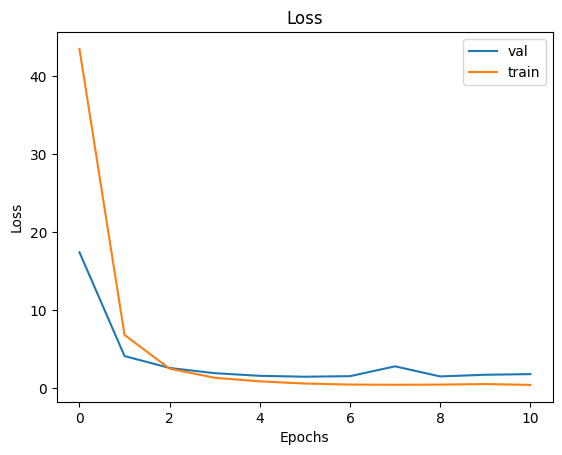

In [35]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
pred = utils.test(simple_model, test_iter)
pred = np.argmax(pred, axis=1)

print(classification_report(y_pred=pred, y_true=test_labels))

              precision    recall  f1-score   support

           0       0.89      0.68      0.77        25
           1       0.67      0.64      0.65        25
           2       0.72      0.72      0.72        25
           3       0.43      0.48      0.45        25
           4       0.84      0.84      0.84        25
           5       0.87      0.80      0.83        25
           6       0.55      0.84      0.67        25
           7       0.85      0.44      0.58        25
           8       0.78      0.72      0.75        25
           9       0.72      0.92      0.81        25

    accuracy                           0.71       250
   macro avg       0.73      0.71      0.71       250
weighted avg       0.73      0.71      0.71       250



As you can see, the model is able to learn something already (which is amazing in itself!). Unfortunately, it saturates too soon. To have a proper go at the problem, we'll need a *much* deeper network. Here, we'll explore an architecture that we adapted from an official `keras` [tutorial](https://keras.io/examples/audio/speaker_recognition_using_cnn/) on the matter. You'll see that this is pretty impressive model, but we simplified it quite a bit.

> *If you would be interested: we took out the residual connections and the average pooling, which didn't lead to a dramatic drop in performance.*

In [24]:
class DeeperModel(nn.Module):
  def __init__(self):
    super(DeeperModel, self).__init__()
    self.cnn =  nn.Sequential(nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3),
                              nn.ReLU(),
                              nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3),
                              nn.ReLU(),
                              nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3),
                              nn.ReLU(),
                              nn.MaxPool1d(2, 2),

                              nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3),
                              nn.ReLU(),
                              nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3),
                              nn.ReLU(),
                              nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3),
                              nn.ReLU(),
                              nn.MaxPool1d(2, 2),

                              nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3),
                              nn.ReLU(),
                              nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3),
                              nn.ReLU(),
                              nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3),
                              nn.ReLU(),
                              nn.MaxPool1d(2, 2),

                              nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3),
                              nn.ReLU(),
                              nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3),
                              nn.ReLU(),
                              nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3),
                              nn.ReLU(),
                              nn.MaxPool1d(2, 2),
                              nn.Dropout(0.5),

                              nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3),
                              nn.ReLU(),
                              nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3),
                              nn.ReLU(),
                              nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3),
                              nn.ReLU(),
                              nn.MaxPool1d(2, 2),
                              nn.Dropout(0.5)
                              )


    self.linear =  nn.Sequential(nn.Linear(38400, 256),
                                nn.Dropout(0.5),
                                 nn.Linear(256, 128),
                                nn.Linear(128, 10))


  def forward(self, x):
    x = torch.unsqueeze(x, 1)
    x = self.cnn(x)
    # print(x.shape)
    x = torch.flatten(x, start_dim=1, end_dim=- 1)
    # print(x.shape)
    x = self.linear(x)
    return x


The model's summary reads like an essay:

In [31]:
deeper_model = DeeperModel()
deeper_model = deeper_model.cuda()

history = utils.train(model=deeper_model,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
              optimizer=torch.optim.Adam(deeper_model.parameters(), lr=0.0001),
              train_ds=train_iter,
              dev_ds=dev_iter,
              num_epochs=100,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=5))

epoch 1 train loss: 2.2628 val_cls: 2.1771 val_acc: 0.1840
tensor(2.1771) None
epoch 2 train loss: 2.1404 val_cls: 2.1005 val_acc: 0.1840
tensor(2.1005) tensor(2.1771)
epoch 3 train loss: 2.0206 val_cls: 2.0000 val_acc: 0.2840
tensor(2.0000) tensor(2.1005)
epoch 4 train loss: 1.9035 val_cls: 1.7515 val_acc: 0.3160
tensor(1.7515) tensor(2.0000)
epoch 5 train loss: 1.7125 val_cls: 1.7085 val_acc: 0.3400
tensor(1.7085) tensor(1.7515)
epoch 6 train loss: 1.4766 val_cls: 1.3311 val_acc: 0.4160
tensor(1.3311) tensor(1.7085)
epoch 7 train loss: 1.2913 val_cls: 1.2062 val_acc: 0.5360
tensor(1.2062) tensor(1.3311)
epoch 8 train loss: 1.1752 val_cls: 1.1333 val_acc: 0.5280
tensor(1.1333) tensor(1.2062)
epoch 9 train loss: 1.0612 val_cls: 0.9952 val_acc: 0.5840
tensor(0.9952) tensor(1.1333)
epoch 10 train loss: 0.9465 val_cls: 0.9663 val_acc: 0.6040
tensor(0.9663) tensor(0.9952)
epoch 11 train loss: 0.8577 val_cls: 0.8430 val_acc: 0.6960
tensor(0.8430) tensor(0.9663)
epoch 12 train loss: 0.8096 v

/content/utils.py:364: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


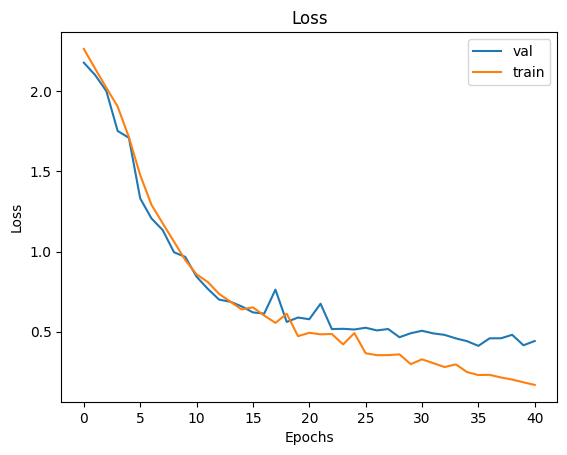

In [32]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
pred = utils.test(deeper_model, test_iter)
pred = np.argmax(pred, axis=1)

print(classification_report(y_pred=pred, y_true=test_labels))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        25
           1       0.88      0.88      0.88        25
           2       0.75      0.84      0.79        25
           3       0.85      0.68      0.76        25
           4       0.92      0.92      0.92        25
           5       0.93      1.00      0.96        25
           6       0.88      0.92      0.90        25
           7       0.88      0.88      0.88        25
           8       0.96      0.92      0.94        25
           9       0.92      0.96      0.94        25

    accuracy                           0.89       250
   macro avg       0.89      0.89      0.89       250
weighted avg       0.89      0.89      0.89       250




This is a deep model, but note that the convolutions make it surprisingly **simple** in terms of parameters: the application of a convolution realizes a process of **weight sharing** across the different time steps. We don't need a separate weight for each of the time steps, as is the case with the traditional dense layer, because the same filters are effectively **reused** across different time slices. In fact, the dense layers in the fully-connected part are much heavier in terms of the number of parameters.



In conclusion: **depth works**, especially for complicated data, like raw audio.